# AISECLAB Phising Email Detection

In [ ]:
import re
import email
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
dataset = pd.read_csv("/content/phishing_emails.csv",index_col=0)
dataset

,text,source,is_phishing
0,Subject: ena offsite\nmy suggestions :\n1 ) mo...,ENRON,0
1,Subject: allegheny energy s - 3\ni received wo...,ENRON,0
2,The University of Washington System is sharing...,https://ciso.uw.edu/education/more-phishing-ex...,1
3,"Dear user@stanford.edu,\n\nA private document ...",https://uit.stanford.edu/phishing,1
4,Subject: james valverde - interview schedule\n...,ENRON,0
...,...,...,...
321,Subject: oto\ni will be out of the office from...,ENRON,0
322,Subject: calpine daily gas nomiantion\nper our...,ENRON,0
323,"Dear Colleague,\nLehigh University have upgrad...",https://lts.lehigh.edu/phishing/examples,1
324,Linkedin Important Profile Changes.\nJust clic...,https://lts.lehigh.edu/phishing/examples,1


In [ ]:
print(dataset.text[0])

Subject: ena offsite
my suggestions :
1 ) mountains ( jackson hole , aspen , banff ) are a nice respite from the houston summer . san diego ( or the baja peninsula ) are also nice - can combine golf , fishing and all kinds of outdoor activities . more exotic locales could include dominican republic , cabo san lucas ( 5 championship courses in vicinity ) , virgin islands , bermuda . i ' m not a big fan of las vegas ( although there is some good golf in the area ) .
2 ) focus should be on ( i ) improving communication across business units ( i ' m surprised by the number of people on this e - mail that i don ' t know ( well ) ) - perhaps presentations by each business unit reviewing 2000 and lh 2001 , ( ii ) identifying opportunities to profit from volatility in commodity and financial markets , ( iii ) create a " road map " strategic plan for the balance of 2001 and full year 2002 .
3 ) i love mountain climbing ( lived in switzerland for four years ) and am happy to organize beginner co

In [ ]:
def get_mail_body(text):
  if "- - - - - original message - - - - -" in text:
    messages = text.split("- - - - - original message - - - - -")
    text = messages[0]
    mail = email.message_from_string(text)
    mail_example = mail.get_payload()
  else:
    mail = email.message_from_string(text)
    mail_example = mail.get_payload()
  return mail_example

## Tokenize

In [ ]:
def clean_text(text):
  stop_words = set(stopwords.words("english"))
  lemmatizer = WordNetLemmatizer()

  text=re.sub(r"^([a-zA-Z0-9]+(\.[a-zA-Z0-9]+)+.*)$|https\S+","", text) # URL kaldırır
  text=re.sub(r"\d+"," ",text) # Sayı Kaldırır
  text=re.sub(r"\W+"," ",text) # Özel Harf kaldırır

  tokens = word_tokenize(text)
  clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words or len(token)>4]

  return " ".join(token for token in clean_tokens)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
dataset["mail_body"]=dataset.text.apply(get_mail_body)
dataset["clean_text"] = dataset.mail_body.apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 0 to 325
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         326 non-null    object
 1   source       326 non-null    object
 2   is_phishing  326 non-null    int64 
 3   mail_body    326 non-null    object
 4   clean_text   326 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.4+ KB


In [ ]:
X=dataset.clean_text.values
y=dataset.is_phishing.values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
from collections import Counter
cn_phishing=Counter()
cn_safe=Counter()

for text,phishing in zip(dataset.clean_text.values,dataset.is_phishing.values):
  for word in text.split():
    if phishing==1:
      cn_phishing[word]+=1
    else:
      cn_safe[word]+=1
  phishing_most_common_words=cn_phishing.most_common(10)
  safe_most_common_words=cn_safe.most_common(10)

print(f"Phishing Most Common \n {phishing_most_common_words} \n\n Safe Most Common Words \n {safe_most_common_words}")

Phishing Most Common 
 [('account', 138), ('email', 105), ('I', 96), ('University', 89), ('mail', 78), ('message', 66), ('You', 66), ('edu', 65), ('Lehigh', 58), ('This', 57)] 

 Safe Most Common Words 
 [('ect', 243), ('enron', 212), ('please', 108), ('hou', 90), ('would', 87), ('vince', 76), ('subject', 75), ('cc', 68), ('com', 67), ('know', 63)]


In [ ]:
vocabulary_size=5000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [ ]:
tokenizer.word_index

{'please': 1,
 'email': 2,
 'account': 3,
 'enron': 4,
 'mail': 5,
 'ect': 6,
 'message': 7,
 'information': 8,
 'university': 9,
 'lehigh': 10,
 'e': 11,
 'com': 12,
 'i': 13,
 'stanford': 14,
 'edu': 15,
 'click': 16,
 'new': 17,
 'u': 18,
 'would': 19,
 'thanks': 20,
 'know': 21,
 'user': 22,
 'need': 23,
 'you': 24,
 'below': 25,
 'service': 26,
 'attached': 27,
 'vince': 28,
 'time': 29,
 'business': 30,
 'may': 31,
 'day': 32,
 'hou': 33,
 'work': 34,
 'link': 35,
 'about': 36,
 'subject': 37,
 'http': 38,
 'help': 39,
 'your': 40,
 'upgrade': 41,
 'there': 42,
 'student': 43,
 'thank': 44,
 'cc': 45,
 'should': 46,
 'contact': 47,
 'this': 48,
 'let': 49,
 'question': 50,
 'update': 51,
 'to': 52,
 'one': 53,
 'like': 54,
 'dear': 55,
 'the': 56,
 'week': 57,
 'support': 58,
 'order': 59,
 'their': 60,
 'number': 61,
 'meeting': 62,
 'address': 63,
 'if': 64,
 'take': 65,
 'mailbox': 66,
 'web': 67,
 'access': 68,
 'server': 69,
 'we': 70,
 'webmail': 71,
 'pm': 72,
 'file': 73,

In [ ]:
print(X_train_tokens[2])

[1, 102, 315, 177, 228, 211, 52, 39, 178, 799, 1290, 68, 657, 47, 658, 177, 1, 102, 315, 211, 39, 65, 1291, 272, 102, 177, 228, 3, 8, 800, 124, 11, 1891, 11, 1292, 229, 1892, 229, 211, 87, 406, 659, 1293, 801, 53, 1293, 273, 1294, 802, 660]


In [ ]:
num_tokens=[len(tokens) for tokens in X_train_tokens+X_test_tokens]
max_tokens = int(np.mean(num_tokens)+2*np.std(num_tokens))
max_tokens

198

In [ ]:
X_train_pad = pad_sequences(X_train_tokens,maxlen=max_tokens)
X_test_pad = pad_sequences(X_test_tokens,maxlen=max_tokens)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size,
                    output_dim=100,
                    input_length=max_tokens))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32,return_sequences=True))
model.add(LSTM(units=16))
model.add(Dense(units=1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 198, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 198, 64)           42240     
                                                                 
 lstm_1 (LSTM)               (None, 198, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 557,809
Trainable params: 557,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train_pad,y_train,epochs=10,batch_size=32)

Epoch 1/10
9/9 [==============================] - 15s 326ms/step - loss: 0.6878 - accuracy: 0.5346
Epoch 2/10
9/9 [==============================] - 2s 258ms/step - loss: 0.6289 - accuracy: 0.8000
Epoch 3/10
9/9 [==============================] - 2s 254ms/step - loss: 0.4505 - accuracy: 0.9154
Epoch 4/10
9/9 [==============================] - 2s 255ms/step - loss: 0.1883 - accuracy: 0.9769
Epoch 5/10
9/9 [==============================] - 2s 203ms/step - loss: 0.0959 - accuracy: 0.9962
Epoch 6/10
9/9 [==============================] - 4s 397ms/step - loss: 0.0698 - accuracy: 0.9962
Epoch 7/10
9/9 [==============================] - 2s 234ms/step - loss: 0.0806 - accuracy: 0.9885
Epoch 8/10
9/9 [==============================] - 2s 232ms/step - loss: 0.0741 - accuracy: 0.9885
Epoch 9/10
9/9 [==============================] - 2s 262ms/step - loss: 0.0695 - accuracy: 0.9885
Epoch 10/10
9/9 [==============================] - 2s 175ms/step - loss: 0.0369 - accuracy: 0.9923


In [ ]:
model.evaluate(X_test_pad,y_test)
y_pred=model.predict(X_test_pad)
y_pred=y_pred.round()

3/3 [==============================] - 0s 13ms/step


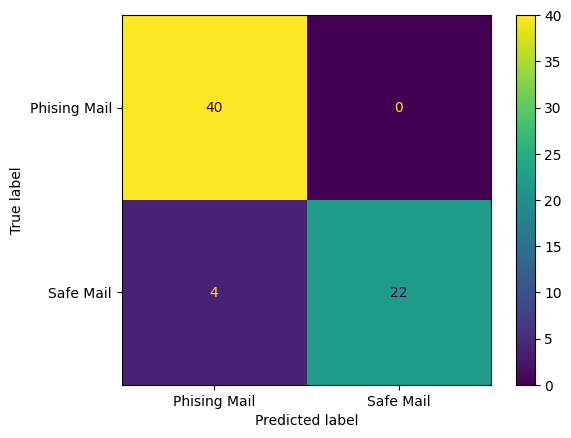

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cmd=ConfusionMatrixDisplay(cm,display_labels=["Phising Mail","Safe Mail"])

cmd.plot()

In [ ]:
phishing_example="""
This is to inform you that your laboratory result is ready.
You can access your results via the following link:
https://results.pmhlaboratoXXXXXXXXX.html(link is external)
You must provide your NAME and DATE OF BIRTH in addition to the
following code in order to see the report:
POP UP BLOCKERS MUST BE DISABLED TO DOWNLOAD PDF REPORTS

Patient Initials: A.B.
Access code: 8625150102
"""

phishing_example= clean_text(phishing_example)
phishing_example_tokens = tokenizer.texts_to_sequences([phishing_example])
phishing_example_pad=pad_sequences(phishing_example_tokens,maxlen=max_tokens)

pred=model.predict(phishing_example_pad)
print(pred.round())

1/1 [==============================] - 0s 47ms/step
[[1.]]


In [ ]:
safe_mail="""
Dear Sir,

I have passed the B.Sc. degree examination with Electronics as the main subject. I intend to have a course in Computer Science and would like to know the details of the courses taught at your institution. Could you please send me a copy of your prospectus?

Yours faithfully,
"""
safe_example = clean_text(safe_mail)
safe_mail_tokens = tokenizer.texts_to_sequences([safe_example])
safe_mail_pad=pad_sequences(safe_mail_tokens,maxlen=max_tokens)
safe_pred=model.predict(safe_mail_pad)
safe_pred.round()

1/1 [==============================] - 0s 28ms/step


array([[1.]], dtype=float32)